In [1]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
import os

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [2]:
data = pd.read_csv('/kaggle/input/crop-recommendation-dataset/Crop_recommendation.csv')
data.head()

,N,P,K,temperature,humidity,ph,rainfall,label
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice


In [3]:
selected_features = data[['temperature', 'humidity', 'rainfall', 'label']]
selected_features.head()

,temperature,humidity,rainfall,label
0,20.879744,82.002744,202.935536,rice
1,21.770462,80.319644,226.655537,rice
2,23.004459,82.320763,263.964248,rice
3,26.491096,80.158363,242.864034,rice
4,20.130175,81.604873,262.717340,rice


In [4]:
selected_features.isnull().value_counts()

temperature  humidity  rainfall  label
False        False     False     False    2200
dtype: int64

In [5]:
X = selected_features.drop('label', axis=1)
y = selected_features['label']

In [6]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

In [8]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [9]:
X_train.shape

(1760, 3)

In [10]:
model = tf.keras.models.Sequential([
    
    tf.keras.layers.Dense(128, activation='relu', input_shape = (3,)),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(22, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               512       
                                                                 
 dense_1 (Dense)             (None, 512)               66048     
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 dense_3 (Dense)             (None, 128)               32896     
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dense_5 (Dense)             (None, 22)                1430      
                                                                 
Total params: 240,470
Trainable params: 240,470
Non-trai

In [11]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [12]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, min_delta=0.005, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=5, min_lr=0.0001)

callback = [early_stopping, reduce_lr]

In [13]:
history = model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, validation_data=(X_test_scaled, y_test), callbacks = [callback])

Epoch 1/100
55/55 [==============================] - 7s 9ms/step - loss: 2.6883 - accuracy: 0.1676 - val_loss: 1.9531 - val_accuracy: 0.3500 - lr: 0.0010
Epoch 2/100
55/55 [==============================] - 0s 5ms/step - loss: 1.6139 - accuracy: 0.3943 - val_loss: 1.4156 - val_accuracy: 0.4614 - lr: 0.0010
Epoch 3/100
55/55 [==============================] - 0s 5ms/step - loss: 1.2699 - accuracy: 0.5085 - val_loss: 1.1130 - val_accuracy: 0.5477 - lr: 0.0010
Epoch 4/100
55/55 [==============================] - 0s 5ms/step - loss: 1.0695 - accuracy: 0.5949 - val_loss: 1.0968 - val_accuracy: 0.6068 - lr: 0.0010
Epoch 5/100
55/55 [==============================] - 0s 5ms/step - loss: 0.9252 - accuracy: 0.6233 - val_loss: 1.0150 - val_accuracy: 0.5932 - lr: 0.0010
Epoch 6/100
55/55 [==============================] - 0s 5ms/step - loss: 0.8899 - accuracy: 0.6415 - val_loss: 0.9102 - val_accuracy: 0.6591 - lr: 0.0010
Epoch 7/100
55/55 [==============================] - 0s 5ms/step - loss: 0.7

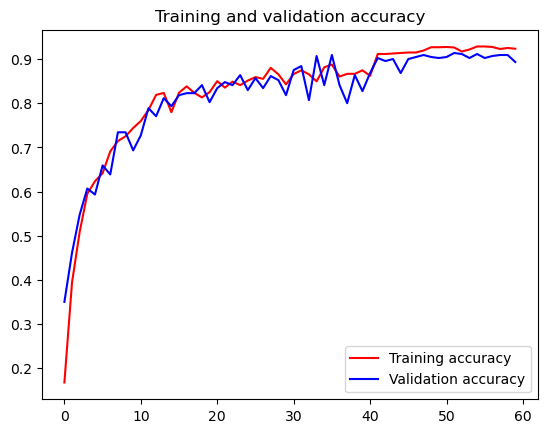

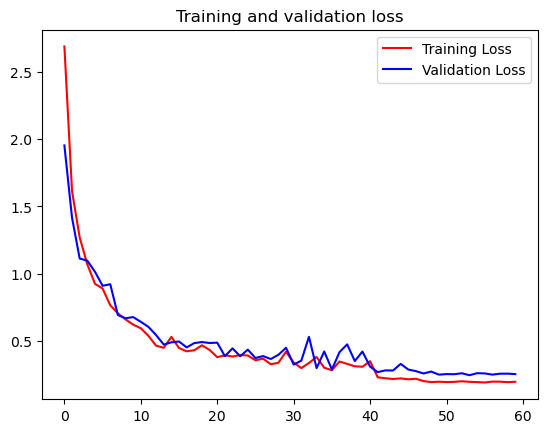

In [14]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [15]:
loss, accuracy = model.evaluate(X_test_scaled, y_test)

14/14 [==============================] - 0s 3ms/step - loss: 0.2502 - accuracy: 0.9023


In [16]:
new_data = pd.DataFrame({'temperature': [22, 25, 35], 'humidity': [82, 70, 80], 'rainfall': [250, 200, 150]})
new_data_scaled = scaler.transform(new_data)

predictions = model.predict(new_data_scaled)

predicted_labels = label_encoder.inverse_transform(np.argmax(predictions, axis=1))

print("Predicted labels:")
for label in predicted_labels:
    print(label)

1/1 [==============================] - 0s 112ms/step
Predicted labels:
rice
jute
papaya


In [17]:
model.save('rec.h5')